# Домашнее задание

Будем практиковаться на датасете недвижимости (sklearn.datasets.fetch_california_housing)

Ваша задача:
1. Создать Dataset для загрузки данных
2. Обернуть его в Dataloader
3. Написать архитектуру сети, которая предсказывает стоимость недвижимости. Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)
4. Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели

train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [17]:
houses = fetch_california_housing()

X = houses.data
y = houses.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13, test_size = 0.25)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((15480, 8), (15480,), (5160, 8), (5160,))

In [18]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
class MyHousing(torch.utils.data.Dataset):
   
    def __init__(self, data, answers):
        self.data = torch.FloatTensor(data)
        self.answers = torch.FloatTensor(answers)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data, lbl = self.data[idx], self.answers[idx]

        return data, lbl

In [20]:
train_dataset = MyHousing(X_train, y_train)
test_dataset = MyHousing(X_test, y_test)
print(f"Train: {len(train_dataset)}, test: {len(test_dataset)}")

Train: 15480, test: 5160


In [6]:
test_dataset[5]

(tensor([0.3461, 0.4706, 0.0348, 0.0203, 0.0466, 0.0024, 0.2019, 0.4442]),
 tensor(2.6830))

In [21]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=40, shuffle=True,
                                          num_workers=2, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=40,
                                          shuffle=False)
print(f"Train: {len(train_loader)}, test: {len(test_loader)}")

Train: 387, test: 129


In [22]:
class Perceptron(nn.Module):
    def __init__(self, input_dim, output_dim, activation="relu"):
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.activation = activation
        
    def forward(self, x):
        x = self.fc(x)
        if self.activation == "relu":
            return F.relu(x)
        if self.activation == "leaky_relu":
            return F.leaky_relu(x)
        raise RuntimeError
        

class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.fc1 = Perceptron(input_dim, 2*hidden_dim)
        self.bn1 = nn.BatchNorm1d(2*hidden_dim)
        self.dp1 = nn.Dropout(0.25)

        self.fc2 = Perceptron(2*hidden_dim, hidden_dim, "relu")
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dp2 = nn.Dropout(0.5)

        self.fc3 = Perceptron(hidden_dim, 1, "relu")
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.dp1(x)
        x = self.bn1(x)

        x = self.fc2(x)
        x = self.dp2(x)
        x = self.bn2(x)

        x = self.fc3(x)

        return x

### Adam

In [13]:
model_1 = FeedForward(8, 387)

name = 'Adam'
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [25]:
?torch.optim.Adam

In [14]:
# сохраняем метрику трейна и теста для каждого оптимизатора
adam_train = []
adam_test = []

print(f"{20*'*'} Optimizer {name} {20*'*'}")

num_epochs = 10

for epoch in range(num_epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader):
        inputs, answers = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = model_1(inputs)
        loss = criterion(outputs, answers)
        # loss = loss.float()
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        true_variance = torch.var(answers)
        running_loss += loss.item()
        running_items += len(answers)
        # running_right += (answers == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 150 == 0:    # печатаем каждые 300 mini-batches
            model_1.eval()
            MSE = running_loss / running_items
            R2 = 1 - MSE/true_variance
            adam_train.append(MSE)
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'MSE: {MSE:.3f}. ' \
                  f'R2: {R2:.3f}', end='. ')

            running_loss, running_items, running_right = 0.0, 0.0, 0.0
            test_running_right, test_running_total, loss_test = 0.0, 0.0, 0.0

            for i, data in enumerate(test_loader):

                inputs_test, answers_test = data[0], data[1]

                test_outputs = model_1(inputs_test)
                loss_test += criterion(test_outputs.squeeze(), answers_test).item()
                test_running_total += len(answers_test)

                MSE_test = loss_test / test_running_total
                true_variance_test = torch.var(answers_test)

                R2_test = 1 - MSE_test/true_variance_test

            print(f'Test MSE: {MSE_test:.3f} Test R2: {R2_test:.3f}')
            # print(f'')
            adam_test.append(MSE_test)
            model_1.train()
    
print('Training is finished!')

******************** Optimizer Adam ********************
Epoch [1/10]. Step [1/387]. MSE: 0.138. R2: 0.917. 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test MSE: 0.141 Test R2: 0.900
Epoch [1/10]. Step [151/387]. MSE: 0.043. R2: 0.973. Test MSE: 0.053 Test R2: 0.963
Epoch [1/10]. Step [301/387]. MSE: 0.034. R2: 0.978. Test MSE: 0.518 Test R2: 0.634
Epoch [2/10]. Step [1/387]. MSE: 0.029. R2: 0.970. Test MSE: 0.303 Test R2: 0.786
Epoch [2/10]. Step [151/387]. MSE: 0.034. R2: 0.979. Test MSE: 0.260 Test R2: 0.816
Epoch [2/10]. Step [301/387]. MSE: 0.033. R2: 0.976. Test MSE: 0.074 Test R2: 0.947
Epoch [3/10]. Step [1/387]. MSE: 0.025. R2: 0.975. Test MSE: 0.109 Test R2: 0.923
Epoch [3/10]. Step [151/387]. MSE: 0.034. R2: 0.977. Test MSE: 0.040 Test R2: 0.971
Epoch [3/10]. Step [301/387]. MSE: 0.033. R2: 0.978. Test MSE: 0.034 Test R2: 0.976
Epoch [4/10]. Step [1/387]. MSE: 0.029. R2: 0.976. Test MSE: 0.035 Test R2: 0.975
Epoch [4/10]. Step [151/387]. MSE: 0.033. R2: 0.961. Test MSE: 0.034 Test R2: 0.976
Epoch [4/10]. Step [301/387]. MSE: 0.033. R2: 0.982. Test MSE: 0.034 Test R2: 0.976
Epoch [5/10]. Step [1/387]. MSE: 0.028. R2: 0.976. 

### RMSProp

In [31]:
model_2 = FeedForward(8, 387)

name = 'RMSProp'
optimizer = torch.optim.RMSprop(model_2.parameters(), lr=0.009, alpha=0.99)
criterion = nn.MSELoss()

In [27]:
# сохраняем метрику трейна и теста для каждого оптимизатора
RMSProp_train = []
RMSProp_test = []

print(f"{20*'*'} Optimizer {name} {20*'*'}")

num_epochs = 10

for epoch in range(num_epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader):
        inputs, answers = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = model_2(inputs)
        loss = criterion(outputs, answers)
        # loss = loss.float()
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        true_variance = torch.var(answers)
        running_loss += loss.item()
        running_items += len(answers)
        # running_right += (answers == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 150 == 0:    # печатаем каждые 300 mini-batches
            model_2.eval()
            MSE = running_loss / running_items
            R2 = 1 - MSE/true_variance
            RMSProp_train.append(MSE)
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'MSE: {MSE:.3f}. ' \
                  f'R2: {R2:.3f}', end='. ')

            running_loss, running_items, running_right = 0.0, 0.0, 0.0
            test_running_right, test_running_total, loss_test = 0.0, 0.0, 0.0

            for i, data in enumerate(test_loader):

                inputs_test, answers_test = data[0], data[1]

                test_outputs = model_2(inputs_test)
                loss_test += criterion(test_outputs.squeeze(), answers_test).item()
                test_running_total += len(answers_test)

                MSE_test = loss_test / test_running_total
                true_variance_test = torch.var(answers_test)

                R2_test = 1 - MSE_test/true_variance_test

            print(f'Test MSE: {MSE_test:.3f} Test R2: {R2_test:.3f}')
            # print(f'')
            RMSProp_test.append(MSE_test)
            model_2.train()
    
print('Training is finished!')

******************** Optimizer RMSProp ********************
Epoch [1/10]. Step [1/387]. MSE: 0.108. R2: 0.904. 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test MSE: 0.195 Test R2: 0.862
Epoch [1/10]. Step [151/387]. MSE: 0.142. R2: 0.903. Test MSE: 0.133 Test R2: 0.906
Epoch [1/10]. Step [301/387]. MSE: 0.052. R2: 0.917. Test MSE: 0.203 Test R2: 0.857
Epoch [2/10]. Step [1/387]. MSE: 0.050. R2: 0.969. Test MSE: 0.822 Test R2: 0.419
Epoch [2/10]. Step [151/387]. MSE: 0.034. R2: 0.960. Test MSE: 0.247 Test R2: 0.825
Epoch [2/10]. Step [301/387]. MSE: 0.034. R2: 0.963. Test MSE: 0.156 Test R2: 0.890
Epoch [3/10]. Step [1/387]. MSE: 0.042. R2: 0.970. Test MSE: 10.161 Test R2: -6.186
Epoch [3/10]. Step [151/387]. MSE: 0.034. R2: 0.964. Test MSE: 0.037 Test R2: 0.974
Epoch [3/10]. Step [301/387]. MSE: 0.034. R2: 0.976. Test MSE: 0.048 Test R2: 0.966
Epoch [4/10]. Step [1/387]. MSE: 0.036. R2: 0.976. Test MSE: 0.346 Test R2: 0.756
Epoch [4/10]. Step [151/387]. MSE: 0.034. R2: 0.977. Test MSE: 0.034 Test R2: 0.976
Epoch [4/10]. Step [301/387]. MSE: 0.033. R2: 0.980. Test MSE: 0.556 Test R2: 0.606
Epoch [5/10]. Step [1/387]. MSE: 0.038. R2: 0.976

### SGD

In [28]:
model_3 = FeedForward(8, 387)

name = 'SGD'
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [29]:
# сохраняем метрику трейна и теста для каждого оптимизатора
SGD_train = []
SGD_test = []

print(f"{20*'*'} Optimizer {name} {20*'*'}")

num_epochs = 10

for epoch in range(num_epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader):
        inputs, answers = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = model_3(inputs)
        loss = criterion(outputs, answers)
        # loss = loss.float()
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        true_variance = torch.var(answers)
        running_loss += loss.item()
        running_items += len(answers)
        # running_right += (answers == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 150 == 0:    # печатаем каждые 300 mini-batches
            model_3.eval()
            MSE = running_loss / running_items
            R2 = 1 - MSE/true_variance
            SGD_train.append(MSE)
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'MSE: {MSE:.3f}. ' \
                  f'R2: {R2:.3f}', end='. ')

            running_loss, running_items, running_right = 0.0, 0.0, 0.0
            test_running_right, test_running_total, loss_test = 0.0, 0.0, 0.0

            for i, data in enumerate(test_loader):

                inputs_test, answers_test = data[0], data[1]

                test_outputs = model_3(inputs_test)
                loss_test += criterion(test_outputs.squeeze(), answers_test).item()
                test_running_total += len(answers_test)

                MSE_test = loss_test / test_running_total
                true_variance_test = torch.var(answers_test)

                R2_test = 1 - MSE_test/true_variance_test

            print(f'Test MSE: {MSE_test:.3f} Test R2: {R2_test:.3f}')
            # print(f'')
            SGD_test.append(MSE_test)
            model_2.train()
    
print('Training is finished!')

******************** Optimizer SGD ********************
Epoch [1/10]. Step [1/387]. MSE: 0.107. R2: 0.917. 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test MSE: 0.136 Test R2: 0.904
Epoch [1/10]. Step [151/387]. MSE: 0.035. R2: 0.977. Test MSE: 0.033 Test R2: 0.976
Epoch [1/10]. Step [301/387]. MSE: 0.034. R2: 0.975. Test MSE: 0.033 Test R2: 0.976
Epoch [2/10]. Step [1/387]. MSE: 0.044. R2: 0.975. Test MSE: 0.033 Test R2: 0.976
Epoch [2/10]. Step [151/387]. MSE: 0.034. R2: 0.973. Test MSE: 0.033 Test R2: 0.976
Epoch [2/10]. Step [301/387]. MSE: 0.034. R2: 0.979. Test MSE: 0.033 Test R2: 0.976
Epoch [3/10]. Step [1/387]. MSE: 0.041. R2: 0.976. Test MSE: 0.033 Test R2: 0.976
Epoch [3/10]. Step [151/387]. MSE: 0.033. R2: 0.976. Test MSE: 0.034 Test R2: 0.976
Epoch [3/10]. Step [301/387]. MSE: 0.033. R2: 0.956. Test MSE: 0.033 Test R2: 0.976
Epoch [4/10]. Step [1/387]. MSE: 0.027. R2: 0.974. Test MSE: 0.033 Test R2: 0.977
Epoch [4/10]. Step [151/387]. MSE: 0.033. R2: 0.970. Test MSE: 0.033 Test R2: 0.976
Epoch [4/10]. Step [301/387]. MSE: 0.034. R2: 0.967. Test MSE: 0.033 Test R2: 0.976
Epoch [5/10]. Step [1/387]. MSE: 0.046. R2: 0.975. 

[]

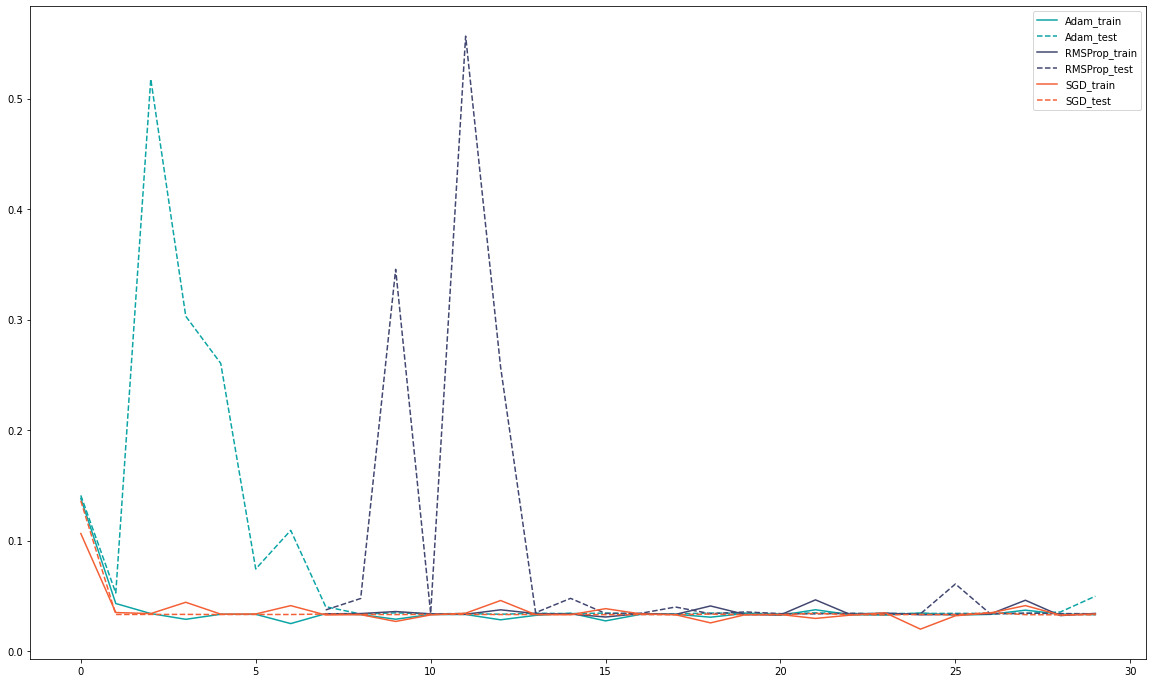

In [36]:
plt.figure(figsize=(20,12))

x_train = np.arange(len(adam_train))
x_test = np.arange(len(adam_test))

plt.plot(x_train, adam_train, linestyle='-' , color='#0CA4A5', label='Adam_train')
plt.plot(x_test, adam_test, linestyle='--' , color='#0CA4A5', label='Adam_test')

plt.plot(x_train[7:], RMSProp_train[7:], linestyle='-' , color='#414770', label='RMSProp_train')
plt.plot(x_test[7:], RMSProp_test[7:], linestyle='--' , color='#414770', label='RMSProp_test')

plt.plot(x_train, SGD_train, linestyle='-' , color='#F46036', label='SGD_train')
plt.plot(x_test, SGD_test, linestyle='--' , color='#F46036', label='SGD_test')

plt.legend()

plt.plot()

В целом, все оптимизаторы показывают хороший результат на данном датасете, но SGD быстрее сошелся, у RMSprop и Adam иногда ошибка зашкаливает